# Enron Scandal: The smartest guys in the room?

## Author: Sagarnil Das
## Date: 28th June, 2017

Enron, a multibillion dollar company in the heart of the Wall Street was one of the largest companies in the United States in 2000. By 2002, it collapsed into bankruptcy due to widespread corporate fraud. They reached a dizzying height only to face a plummeting collapse. The bankruptcy of Enron affected thousands of its employees and shook the whole Wall Street by its foundation. In the federal investigation that followed, all the emails from Enron employees were made public. Since then these emails have spreaded like a wildfire through the world and many analysis and investigations have been done on this data. In this project, my target is to build a ** Person of Interest ** identifier/Label and try to build a Machine Learning Algorithm to predict the possible Persons of Interest based on various features.

## Initial Preparation/Importing Libraries

In [57]:
import matplotlib.pyplot as plt
import sys
import pickle
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from time import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.grid_search import GridSearchCV
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
import pprint
import warnings
warnings.filterwarnings('ignore')

## Create Features list and Import necessary files

In [5]:
features_list = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments',
                 'loan_advances', 'bonus', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person',
                 'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi',
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

## Initial data exploration

In [6]:
#Sample data for one of the Top executives - Jeffrey Skilling
pprint.pprint(data_dict["SKILLING JEFFREY K"])

#Number of people in the datasets

print "Total number of people in the dataset: " + str(len(data_dict))

#Number of features available in the dataset

print "Total number of features in the dataset: " + str(len(data_dict["SKILLING JEFFREY K"]))

#Number of POIs in the dataset

def poi_count(file):
    count = 0
    for data in file:
        if file[data]['poi'] == True:
            count += 1
    print "Number of POIs in the dataset: " + str(count)

poi_count(data_dict)


{'bonus': 5600000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'jeff.skilling@enron.com',
 'exercised_stock_options': 19250000,
 'expenses': 29336,
 'from_messages': 108,
 'from_poi_to_this_person': 88,
 'from_this_person_to_poi': 30,
 'loan_advances': 'NaN',
 'long_term_incentive': 1920000,
 'other': 22122,
 'poi': True,
 'restricted_stock': 6843672,
 'restricted_stock_deferred': 'NaN',
 'salary': 1111258,
 'shared_receipt_with_poi': 2042,
 'to_messages': 3627,
 'total_payments': 8682716,
 'total_stock_value': 26093672}
Total number of people in the dataset: 146
Total number of features in the dataset: 21
Number of POIs in the dataset: 18


## Detect outliers and remove them

Now we will consider a few features where having outliers can significantly affect our whole analysis. We will analyze these outliers to see whether they should be there or we can remove them to make our analysis more robust.

97343619.0


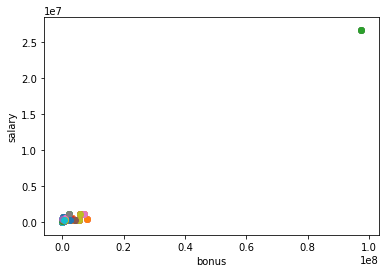

In [11]:
features = ["bonus","salary"]
data = featureFormat(data_dict, features)
print(data.max())

for point in data:
    bonus = point[0]
    salary = point[1]
    plt.scatter( bonus, salary )

plt.xlabel("bonus")
plt.ylabel("salary")
plt.show()

WOW! That's a huge outlier right there in the upper right corner! In fact it is so big that it is making all the other points insignificant in scale. So what's going on over there? Looking at the dataset, we see it is an excel artifact which calculated the ** TOTAL ** value or the sum. So it should be removed. Another point which should be removed is ** THE TRAVEL AGENCY IN THE PARK **. Both of these values does not belong to any individual and thus not significant for our analysis. We also try to find out who got the maximum salary and the maximum bonus.

## Maximum Salary

In [13]:
outliers_salary = []
for key in data_dict:
    val = data_dict[key]['salary']
    if val == 'NaN':
        continue
    outliers_salary.append((key,int(val)))

pprint.pprint(sorted(outliers_salary,key=lambda x:x[1],reverse=True)[:2])

[('TOTAL', 26704229), ('SKILLING JEFFREY K', 1111258)]


## Maximum Bonus

In [14]:
from pprint import pprint
outliers_bonus = []
for key in data_dict:
    val = data_dict[key]['bonus']
    if val == 'NaN':
        continue
    outliers_bonus.append((key,int(val)))

pprint(sorted(outliers_bonus,key=lambda x:x[1],reverse=True)[:2])

[('TOTAL', 97343619), ('LAVORATO JOHN J', 8000000)]


Thats's some insane amount of money right there!

## Removing Total and Travel Agency in the Park outliers

In [15]:
data_dict.pop('TOTAL',0)
data_dict.pop('THE TRAVEL AGENCY IN THE PARK',0)

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}

## Plotting after outlier removal

We will try to plot the same plot. Now that we have removed the huge outliers, we should expect to see something much different than what we saw before.


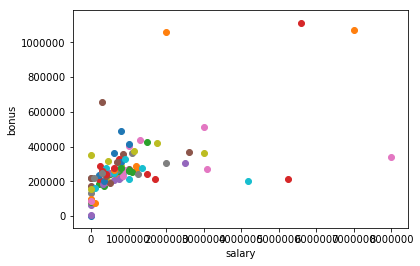

In [43]:
my_dataset = data_dict
my_feature_list = features_list
data = featureFormat(data_dict, features)
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )


plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

## Investigating emails from and to a Person of Interest

Now we will investigate from_this_person_to_poi and from_poi_to_this_person for any outliers as they are important features

609.0


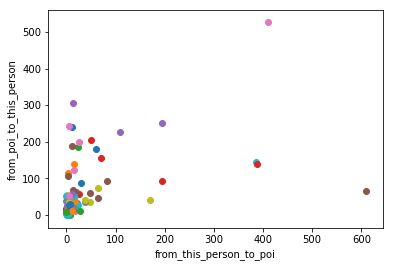

In [44]:
features = ["from_this_person_to_poi", "from_poi_to_this_person"]
data = featureFormat(data_dict, features)

print data.max()
#Plotting the graph
for point in data:
    from_this_person_to_poi = point[0]
    from_poi_to_this_person = point[1]
    plt.scatter( from_this_person_to_poi, from_poi_to_this_person )

plt.xlabel("from_this_person_to_poi")
plt.ylabel("from_poi_to_this_person")
plt.show()


Here we see a few outliers. But on investigation, I found out that they are real persons and not data error. So I am going to keep them in the dataset

## Dealing with 'NaN' values

In [45]:
#Making dataframes in pandas one for the keys and one for the values

df_values = pd.DataFrame.from_records(list(data_dict.values()))
df_values.head()

df_persons = pd.Series(list(data_dict.keys()))
df_persons.head()

#We see lot's of NaN values. So we have to take care of that. We will convert them to numpy nan and then to zero.
df_values.replace(to_replace='NaN', value=np.nan, inplace=True)

# Count number of NaN's for columns
print df_values.isnull().sum()

# DataFrame dimension
print df_values.shape


df_null = df_values.replace(to_replace=np.nan, value=0)
df_null = df_values.fillna(0).copy(deep=True)
df_null.columns = list(df_values.columns.values)
print df_null.isnull().sum()
print df_null.head()

df_null.describe()


bonus                         63
deferral_payments            106
deferred_income               96
director_fees                128
email_address                 33
exercised_stock_options       43
expenses                      50
from_messages                 58
from_poi_to_this_person       58
from_this_person_to_poi       58
loan_advances                141
long_term_incentive           79
other                         53
poi                            0
restricted_stock              35
restricted_stock_deferred    127
salary                        50
shared_receipt_with_poi       58
to_messages                   58
total_payments                21
total_stock_value             19
dtype: int64
(144, 21)
bonus                        0
deferral_payments            0
deferred_income              0
director_fees                0
email_address                0
exercised_stock_options      0
expenses                     0
from_messages                0
from_poi_to_this_person      0
from_

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,1.440000e+02,1.440000e+02,1.440000e+02,144.000000,1.440000e+02,144.000000,144.000000,144.000000,144.000000,1.440000e+02,1.440000e+02,1.440000e+02,1.440000e+02,1.440000e+02,1.440000e+02,144.000000,144.000000,1.440000e+02,1.440000e+02
mean,6.759974e+05,2.220896e+05,-1.936833e+05,9980.319444,2.075802e+06,35375.340278,363.583333,38.756944,24.625000,5.828125e+05,3.369578e+05,2.947455e+05,8.685363e+05,7.341790e+04,1.854460e+05,702.611111,1238.555556,2.256543e+06,2.909786e+06
std,1.233155e+06,7.541013e+05,6.060111e+05,31300.575144,4.795513e+06,45309.303038,1450.675239,74.276769,79.778266,6.794472e+06,6.871826e+05,1.131325e+06,2.016572e+06,1.301983e+06,1.970421e+05,1077.290736,2237.564816,8.847189e+06,6.189018e+06
min,0.000000e+00,-1.025000e+05,-3.504386e+06,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-2.604490e+06,-1.787380e+06,0.000000e+00,0.000000,0.000000,0.000000e+00,-4.409300e+04
25%,0.000000e+00,0.000000e+00,-3.708600e+04,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.434500e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,9.019275e+04,2.443265e+05
50%,3.000000e+05,0.000000e+00,0.000000e+00,0.000000,6.082935e+05,20182.000000,17.500000,4.000000,0.000000,0.000000e+00,0.000000e+00,9.190000e+02,3.605280e+05,0.000000e+00,2.105960e+05,114.000000,347.500000,9.413595e+05,9.659550e+05
75%,8.000000e+05,8.535500e+03,0.000000e+00,0.000000,1.683580e+06,53328.250000,53.000000,41.250000,14.000000,0.000000e+00,3.745862e+05,1.485770e+05,7.374560e+05,0.000000e+00,2.696675e+05,933.750000,1623.000000,1.945668e+06,2.295176e+06
max,8.000000e+06,6.426990e+06,0.000000e+00,137864.000000,3.434838e+07,228763.000000,14368.000000,528.000000,609.000000,8.152500e+07,5.145434e+06,1.035973e+07,1.476169e+07,1.545629e+07,1.111258e+06,5521.000000,15149.000000,1.035598e+08,4.911008e+07


## Feature selection

For selecting the best features I am going to use SelectKBest method from scikit-learn. I am going to choose the top 11 features.

In [46]:
def get_k_best(enron_data, features_list, k):
    """ runs scikit-learn's SelectKBest feature selection
        returns dict where keys=features, values=scores
    """
    data = featureFormat(data_dict, features_list)
    labels, features = targetFeatureSplit(data)

    k_best = SelectKBest(k=k)
    k_best.fit(features, labels)
    scores = k_best.scores_
    unsorted_pairs = zip(features_list[1:], scores)
    sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))
    k_best_features = dict(sorted_pairs[:k])
    print "{0} best features: {1}\n".format(k, k_best_features.keys())
    print k_best_features
    return k_best_features

target_label = 'poi'
num_features = 11 # 11 best features
top_features = get_k_best(data_dict, features_list, num_features)
print top_features
my_feature_list = [target_label] + top_features.keys()
# print my_feature_list

print "{0} selected features: {1}\n".format(len(my_feature_list) - 1, my_feature_list[1:])

features_list = my_feature_list


11 best features: ['salary', 'total_payments', 'loan_advances', 'bonus', 'total_stock_value', 'shared_receipt_with_poi', 'exercised_stock_options', 'deferred_income', 'expenses', 'restricted_stock', 'long_term_incentive']

{'salary': 18.289684043404513, 'total_payments': 8.7727777300916792, 'loan_advances': 7.1840556582887247, 'bonus': 20.792252047181535, 'total_stock_value': 24.182898678566879, 'shared_receipt_with_poi': 8.589420731682381, 'exercised_stock_options': 24.815079733218194, 'deferred_income': 11.458476579280369, 'expenses': 6.0941733106389453, 'restricted_stock': 9.2128106219771002, 'long_term_incentive': 9.9221860131898225}
{'salary': 18.289684043404513, 'total_payments': 8.7727777300916792, 'loan_advances': 7.1840556582887247, 'bonus': 20.792252047181535, 'total_stock_value': 24.182898678566879, 'shared_receipt_with_poi': 8.589420731682381, 'exercised_stock_options': 24.815079733218194, 'deferred_income': 11.458476579280369, 'expenses': 6.0941733106389453, 'restricted_st

## Feature Engineering

Now let's add some new features of interest to the list of the features. I will make three functions to do that. 

## Proportion of email interaction with POIs

In [47]:
def add_poi_ratio(data_dict, features_list):
    """ mutates data dict to add proportion of email interaction with pois """
    fields = ['to_messages', 'from_messages',
              'from_poi_to_this_person', 'from_this_person_to_poi']
    for record in data_dict:
        person = data_dict[record]
        is_valid = True
        for field in fields:
            if person[field] == 'NaN':
                is_valid = False
        if is_valid:
            total_messages = person['to_messages'] +\
                             person['from_messages']
            poi_messages = person['from_poi_to_this_person'] +\
                           person['from_this_person_to_poi']
            person['poi_ratio'] = float(poi_messages) / total_messages
        else:
            person['poi_ratio'] = 'NaN'
    features_list += ['poi_ratio']



## Proportion of emails to POIs

In [48]:
def add_fraction_to_poi(data_dict, features_list):
    """ mutates data dict to add proportion of email fraction_to_poi """
    fields = ['from_messages', 'from_this_person_to_poi']
    for record in data_dict:
        person = data_dict[record]
        is_valid = True
        for field in fields:
            if person[field] == 'NaN':
                is_valid = False
        if is_valid:
            total_messages = person['from_messages']
            poi_messages =   person['from_this_person_to_poi']
            person['fraction_to_poi'] = float(poi_messages) / total_messages
        else:
            person['fraction_to_poi'] = 'NaN'
    features_list += ['fraction_to_poi']


## Proportion of emails from POIs

In [49]:
def add_fraction_from_poi(data_dict, features_list):
    """ mutates data dict to add proportion of email fraction_to_poi """
    fields = ['to_messages', 'from_poi_to_this_person']
    for record in data_dict:
        person = data_dict[record]
        is_valid = True
        for field in fields:
            if person[field] == 'NaN':
                is_valid = False
        if is_valid:
            total_messages = person['to_messages']
            poi_messages =   person['from_poi_to_this_person']
            person['fraction_from_poi'] = float(poi_messages) / total_messages
        else:
            person['fraction_from_poi'] = 'NaN'
    features_list += ['fraction_from_poi']


## Adding them to the features list

In [51]:
add_poi_ratio(data_dict, my_feature_list)
add_fraction_to_poi(data_dict, my_feature_list)
add_fraction_from_poi(data_dict, my_feature_list)

print my_feature_list

features_list = my_feature_list
my_dataset = data_dict

['poi', 'salary', 'total_payments', 'loan_advances', 'bonus', 'total_stock_value', 'shared_receipt_with_poi', 'exercised_stock_options', 'deferred_income', 'expenses', 'restricted_stock', 'long_term_incentive', 'poi_ratio', 'fraction_to_poi', 'fraction_from_poi']


## Extract features and labels from dataset for local testing

In [52]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

## Scaling the features by MinMaxScaler from Sklearn preprocessing module

In [54]:
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

## Splitting the data into train data(70%) and test data(30%)

In [55]:
features_train,features_test,labels_train,labels_test = cross_validation.train_test_split(features,labels, test_size=0.3, 
                                                                                          random_state=42)

## Using different Machine Learning Classifiers

We will iterate through variety of classifiers to see which one's prediction is the best.

## Decision Tree Classifier

In [66]:
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test,pred)
print("Decision Tree Classifier: ")
print "Accuracy: " + str(accuracy)
print "Precision Score: " + str(precision_score(labels_test,pred))
print "Recall Score: " + str(recall_score(labels_test,pred))

Decision Tree Classifier: 
Accuracy: 0.860465116279
Precision Score: 0.333333333333
Recall Score: 0.2


## Random Forest Classifier

In [59]:
clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=10)
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test,pred)
print("Random Forest Classifier: ")
print "Accuracy: " + str(accuracy)
print "Precision Score: " + str(precision_score(labels_test,pred))
print "Recall Score: " + str(recall_score(labels_test,pred))

Random Forest Classifier: 
Accuracy: 0.813953488372
Precision Score: 0.2
Recall Score: 0.2


## Naive Bayes Classifier

In [60]:
clf = GaussianNB()
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test,pred)
print("Naive Bayes Classifier: ")
print "Accuracy: " + str(accuracy)
print "Precision Score: " + str(precision_score(labels_test,pred))
print "Recall Score: " + str(recall_score(labels_test,pred))

Naive Bayes Classifier: 
Accuracy: 0.860465116279
Precision Score: 0.4
Recall Score: 0.4


## AdaBoost Classifier

In [67]:
clf = AdaBoostClassifier()
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test,pred)
print("Adaboost Classifier: ")
print "Accuracy: " + str(accuracy)
print "Precision Score: " + str(precision_score(labels_test,pred))
print "Recall Score: " + str(recall_score(labels_test,pred))

Adaboost Classifier: 
Accuracy: 0.837209302326
Precision Score: 0.25
Recall Score: 0.2


## Standard Vector Machine (rbf) Classifier

In [68]:
clf = SVC(gamma=3, C=2)
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test,pred)
print("SVM Classifier: ")
print "Accuracy: " + str(accuracy)
print "Precision Score: " + str(precision_score(labels_test,pred))
print "Recall Score: " + str(recall_score(labels_test,pred))

SVM Classifier: 
Accuracy: 0.860465116279
Precision Score: 0.0
Recall Score: 0.0


## K Nearest Neighbours Classifier

In [69]:
clf = KNeighborsClassifier(3)
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test,pred)
print("SVM Classifier: ")
print "Accuracy: " + str(accuracy)
print "Precision Score: " + str(precision_score(labels_test,pred))
print "Recall Score: " + str(recall_score(labels_test,pred))

SVM Classifier: 
Accuracy: 0.837209302326
Precision Score: 0.0
Recall Score: 0.0


So we see that the Decision Tree classifier is giving us one of the best accuracy rates around the range of 83-86%. So we will use this classifier and fine tune it to increase the accuracy of the model even more. We will use GridSearchCV to tune this classifier.

In [70]:
from sklearn import grid_search
from sklearn.metrics import f1_score

In [71]:
cv = cross_validation.StratifiedShuffleSplit(labels, n_iter=10)


def scoring(estimator, features_test, labels_test):
    labels_pred = estimator.predict(features_test)
    p = precision_score(labels_test, labels_pred, average='micro')
    r = recall_score(labels_test, labels_pred, average='micro')
    if p > 0.3 and r > 0.3:
        return f1_score(labels_test, labels_pred, average='macro')
    return 0


## Decision Tree Classifier Tuning

In [72]:
t0 = time()
parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 8, 9, 10], 'min_samples_split': [2],
              'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8], 'criterion': ('gini', 'entropy')}

decTree_clf = DecisionTreeClassifier(max_depth=10)
decTreeclf = grid_search.GridSearchCV(decTree_clf, parameters, scoring=scoring, cv=cv)

decTreeclf.fit(features, labels)
print decTreeclf.best_estimator_
print decTreeclf.best_score_
print 'Processing time:', round(time() - t0, 3), 's'

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
0.804156491656
Processing time: 15.074 s


## Classifier Validation

In [73]:
##DecisionTreeClassifier Validation 1 (StratifiedShuffleSplit, folds = 1000)
from tester import test_classifier
t0 = time()
decTree_best_clf = decTreeclf.best_estimator_
test_classifier(decTree_best_clf, my_dataset, features_list)
print 'Processing time:', round(time() - t0, 3), 's'

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.87820	Precision: 0.55356	Recall: 0.44700	F1: 0.49461	F2: 0.46490
	Total predictions: 15000	True positives:  894	False positives:  721	False negatives: 1106	True negatives: 12279

Processing time: 3.581 s


In [79]:
##DecisionTreeClassifier Validation 2  (Cross validation)

from sklearn.model_selection import cross_val_score
t0 = time()
decTree_best_clf = decTreeclf.best_estimator_
scores = cross_val_score(decTree_best_clf, features, labels, cv=5,scoring = 'accuracy')
print("Accuracy and Deviation: " + str((scores.mean(), scores.std() * 2)))
print 'Processing time:', round(time() - t0, 3), 's'
test_classifier(decTree_best_clf, my_dataset, features_list)

Accuracy and Deviation: (0.86724137931034484, 0.081577306579249109)
Processing time: 0.058 s
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.87773	Precision: 0.55130	Recall: 0.44600	F1: 0.49309	F2: 0.46371
	Total predictions: 15000	True positives:  892	False positives:  726	False negatives: 1108	True negatives: 12274



## Improvement in our machine learning classifier

So we see by applying Stratified Shuffle Split to our Decision Tree Classifier, we are able to improve the accuracy of our classifier by more than ** 1% **. So right now, it is giving us an accuracy of ** ~87% **. We also see that ratio of the false positives to true positives is much higher than the ratio of false negatives to true negatives. This is actually good for us because we would rather mark a person as POI who in reality is not a POI than not able to catch the Real POIs and marking them as False POIs. My argument here is even though we mark someone as a POI wrongly, he/she will still get through unscathed after investigation. But on the other hand, if we miss someone who is indeed guilty, then that person is just not facing the justice as he/she should have. 